In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import torch

## Identify signal in GEDI waveforms using an autoencoder

This notebook is based on [this keras tutorial](https://keras.io/examples/timeseries/timeseries_anomaly_detection/).

### Prepare input data

We need to get the waveforms as numpy arrays, holding onto metadata for assessing site differences etc.

In [2]:
df = pd.read_excel("data_in/7_RF_comparison.xlsx")
print(df.head())
print(df.columns)

         shot_number   Latitude  Longitude  srtm_elevation      beam  \
0  35900000300217679  42.447524 -72.225575      204.270370  BEAM0000   
1  35900000300217681  42.446941 -72.224430      201.268753  BEAM0000   
2  35900000300217688  42.444899 -72.220428      195.263092  BEAM0000   
3  35900000300217690  42.444316 -72.219284      191.261337  BEAM0000   
4  35900100300212910  42.454033 -72.225249      215.283478  BEAM0001   

         date                                      GEDI_L1B_File  \
0  2019\08\01  H:\2-LiDAR-clumpingIndex\GEDIDownloading\Globa...   
1  2019\08\01  H:\2-LiDAR-clumpingIndex\GEDIDownloading\Globa...   
2  2019\08\01  H:\2-LiDAR-clumpingIndex\GEDIDownloading\Globa...   
3  2019\08\01  H:\2-LiDAR-clumpingIndex\GEDIDownloading\Globa...   
4  2019\08\01  H:\2-LiDAR-clumpingIndex\GEDIDownloading\Globa...   

                                       GEDI_L2B_File  \
0  H:\2-LiDAR-clumpingIndex\GEDIDownloading\Globa...   
1  H:\2-LiDAR-clumpingIndex\GEDIDownloading\Gl

In [3]:
metadata_cols = [
    "shot_number", "Latitude", "Longitude", "date", "site", "toploc", "botloc"
]

metadata = df[metadata_cols]

# Can't stack these because they are differing lengths
waveforms = df["rxwaveform"].map(lambda x: np.array(list(map(float, x.split(",")))))

In [4]:
noise_region = 100
window_size = 64
stride = 8

def get_noise_samples(arr):
    '''
    Extracts the beginning and end sequences of `arr` of size noise_region,
    then unfolds them into windows of a given size and stride.

    See https://pytorch.org/docs/stable/generated/torch.Tensor.unfold.html.
    '''
    return torch.cat([
        torch.tensor(arr[:noise_region]).unfold(0, size=window_size, step=stride),
        torch.tensor(arr[-noise_region:]).unfold(0, size=window_size, step=stride)
    ])

# Test
samples = get_noise_samples(waveforms[0])
print(samples.shape)

torch.Size([10, 64])


In [5]:
# Split the waveforms into train/valid/test before we go any further.
# This is roughly a 60-20-20 split.
n = waveforms.shape[0]
inds = np.arange(n)
np.random.shuffle(inds)

train_inds, valid_inds, test_inds = np.split(inds, [int(n * 0.6), int(n * 0.8)])
print("Count of waveforms")
print("Training:", train_inds.shape[0])
print("Validation:", valid_inds.shape[0])
print("Testing:", test_inds.shape[0])

Count of waveforms
Training: 3843
Validation: 1281
Testing: 1281


In [6]:
# Now generate samples from the training set.
# All of these samples are *noise*.
dtype = torch.float32

train_waveforms = waveforms[train_inds]
valid_waveforms = waveforms[valid_inds]
test_waveforms  = waveforms[test_inds]

# Add a channel axis with unsqueeze
train_samples = torch.cat([get_noise_samples(a) for a in train_waveforms]).unsqueeze(1).to(torch.float32)
valid_samples = torch.cat([get_noise_samples(a) for a in valid_waveforms]).unsqueeze(1).to(torch.float32)

print("Count of train samples:", train_samples.shape[0])
print("Count of valid samples:", valid_samples.shape[0])

Count of train samples: 38430
Count of valid samples: 12810


### Prepare DataLoaders

DataLoaders are classes used by torch to supply data to a model. This takes care of batching and shuffling for us.

In [7]:
batch_size = 128

# We don't separate X and Y here because we are making a reconstruction model.
train_ds = torch.utils.data.TensorDataset(train_samples)
valid_ds = torch.utils.data.TensorDataset(valid_samples)

train_dl = torch.utils.data.DataLoader(train_ds, batch_size=batch_size, shuffle=True)
valid_dl = torch.utils.data.DataLoader(valid_ds, batch_size=batch_size, shuffle=True)

In [8]:
batch = next(iter(train_dl))
print(batch[0].shape)

torch.Size([128, 1, 64])


### Model Definition

This is an identical model structure to the keras tutorial linked above, but including a batchnorm layer so that we don't have to normalize waveforms as part of our data pipeline.

In [9]:
from collections import OrderedDict

def count_trainable_parameters(m):
    '''
    Determine model size.
    '''
    return sum(p.numel() for p in m.parameters() if p.requires_grad)

class Autoencoder(torch.nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.batchnorm = torch.nn.BatchNorm1d(1)
        self.conv1 = torch.nn.Conv1d(in_channels=1, out_channels=32, kernel_size=8)
        self.conv2 = torch.nn.Conv1d(in_channels=32, out_channels=16, kernel_size=8)
        self.tconv1 = torch.nn.ConvTranspose1d(in_channels=16, out_channels=32, kernel_size=8)
        self.tconv2 = torch.nn.ConvTranspose1d(in_channels=32, out_channels=1, kernel_size=8)
        
        self.relu = torch.nn.ReLU()
        self.drop = torch.nn.Dropout(0.3)

    def forward(self, X):
        X = self.batchnorm(X)
        # Keep the batchnormed result
        X_bn = X.detach().clone()

        X = self.conv1(X)
        X = self.relu(X)
        X = self.drop(X)

        X = self.conv2(X)
        X = self.relu(X)

        X = self.tconv1(X)
        X = self.relu(X)
        X = self.drop(X)

        X = self.tconv2(X)

        return X, X_bn

# This is quick way of defining a model, lots of customization
# is possible here.
model = Autoencoder()
print("Number of parameters in model:", count_trainable_parameters(model))

# Test model and make sure that the shapes match.
# Our goal here is to reproduce the input.
test_input = batch[0]
test_output, _ = model(test_input)
print(test_output.shape)
assert test_input.shape == test_output.shape

Number of parameters in model: 8787
torch.Size([128, 1, 64])


### Training loop

Since we are training on literal noise, the model almost certainly won't learn anything. The hope is that the signal will have a much different loss than the noise regions.

In [10]:
from tqdm.autonotebook import tqdm

n_epochs = 10
learning_rate = 0.0005

loss = torch.nn.MSELoss()
opt = torch.optim.Adam(model.parameters(), lr=learning_rate)

for i_epoch in tqdm(range(n_epochs), desc="epoch"):
    # Initialize
    epoch_loss = 0
    val_loss = 0
    n_batches = 0
    opt.zero_grad()

    # Optimize on training set
    for batch in tqdm(train_dl, desc="training", leave=False):
        input = batch[0]
        output, input_bn = model(input)
        
        batch_loss = loss(output, input_bn)
        batch_loss.backward()

        opt.step()

        epoch_loss += batch_loss.item()

    # Check on validation set
    with torch.no_grad():
        model.eval()
        for batch in tqdm(valid_dl, desc="validation", leave=False):
            input = batch[0]
            output, input_bn = model(input)

            batch_loss = loss(output, input_bn)
            val_loss += batch_loss.item()
        model.train()

    # Report results
    print(f"Epoch {i_epoch}: Training loss - {batch_loss/len(train_dl):.5f}\tValidation loss - {val_loss/len(valid_dl):.5f}")

/tmp/ipykernel_15754/4020423153.py:1: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


epoch:   0%|          | 0/10 [00:00<?, ?it/s]

training:   0%|          | 0/301 [00:00<?, ?it/s]

validation:   0%|          | 0/101 [00:00<?, ?it/s]

Epoch 0: Training loss - 0.00152	Validation loss - 0.44939


training:   0%|          | 0/301 [00:00<?, ?it/s]

validation:   0%|          | 0/101 [00:00<?, ?it/s]

Epoch 1: Training loss - 0.00061	Validation loss - 0.33965


training:   0%|          | 0/301 [00:00<?, ?it/s]

validation:   0%|          | 0/101 [00:00<?, ?it/s]

Epoch 2: Training loss - 0.00130	Validation loss - 0.32074


training:   0%|          | 0/301 [00:00<?, ?it/s]

validation:   0%|          | 0/101 [00:00<?, ?it/s]

Epoch 3: Training loss - 0.00182	Validation loss - 0.33700


training:   0%|          | 0/301 [00:00<?, ?it/s]

validation:   0%|          | 0/101 [00:00<?, ?it/s]

Epoch 4: Training loss - 0.00162	Validation loss - 0.42087


training:   0%|          | 0/301 [00:00<?, ?it/s]

validation:   0%|          | 0/101 [00:00<?, ?it/s]

Epoch 5: Training loss - 0.00142	Validation loss - 0.25332


training:   0%|          | 0/301 [00:00<?, ?it/s]

validation:   0%|          | 0/101 [00:00<?, ?it/s]

Epoch 6: Training loss - 0.00050	Validation loss - 0.22295


training:   0%|          | 0/301 [00:00<?, ?it/s]

validation:   0%|          | 0/101 [00:00<?, ?it/s]

Epoch 7: Training loss - 0.00065	Validation loss - 0.21774


training:   0%|          | 0/301 [00:00<?, ?it/s]

validation:   0%|          | 0/101 [00:00<?, ?it/s]

Epoch 8: Training loss - 0.00051	Validation loss - 0.20494


training:   0%|          | 0/301 [00:00<?, ?it/s]

validation:   0%|          | 0/101 [00:00<?, ?it/s]

Epoch 9: Training loss - 0.00066	Validation loss - 0.20396


### Calculate loss on entire signal

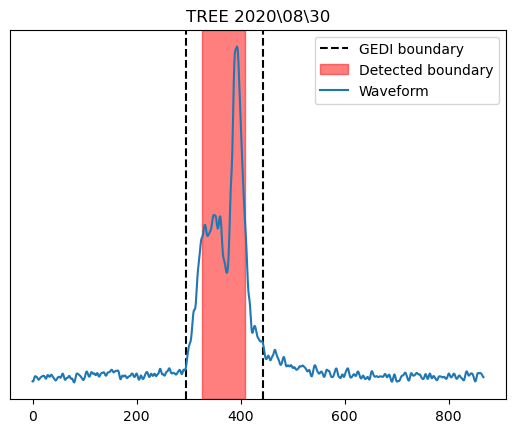

In [11]:
loss_threshold = 1 # arbitrary

def rescale(arr):
    arr_min = np.nanmin(arr)
    arr_max = np.nanmax(arr)
    return (arr - arr_min) / (arr_max - arr_min)

def waveform_model_loss(arr):
    windows = torch.tensor(arr).to(dtype).unfold(0, size=window_size, step=stride).unsqueeze(1)

    output, input_bn = model(windows)
    model_error = ((output - input_bn) ** 2).squeeze(1)

    waveform_tot_error = torch.zeros(arr.shape)
    waveform_n = torch.zeros(arr.shape)

    for i in range(model_error.shape[0]):
        start = i * stride
        end = start+window_size
        waveform_tot_error[start:end] += model_error[i, :]
        waveform_n[start:end] += 1

    waveform_avg_error = waveform_tot_error / waveform_n

    return waveform_avg_error.detach().numpy()

def plot_waveform_result(idx, ax=None):
    waveform = test_waveforms.iloc[idx]
    metadata = df.iloc[test_waveforms.index[idx]]

    waveform_loss = waveform_model_loss(waveform)

    signal_points = np.where(waveform_loss > loss_threshold)
    signal_start = signal_points[0][0]
    signal_end = signal_points[0][-1]

    if ax is None:
        _, ax = plt.subplots()

    # Plot GEDI boundaries
    ax.axvline(metadata["toploc"], color="black", linestyle="--", label="GEDI boundary")
    ax.axvline(metadata["botloc"], color="black", linestyle="--")

    # Plot our boundaries
    ax.axvspan(signal_start, signal_end, color="red", alpha=0.5, label="Detected boundary")
    
    # Plot waveform
    ax.plot(waveform, label="Waveform")
    ax.yaxis.set_ticks([])

    ax.set_title(metadata["site"] + " " + metadata["date"])

    return ax


plot_waveform_result(0)
plt.legend()
plt.show()

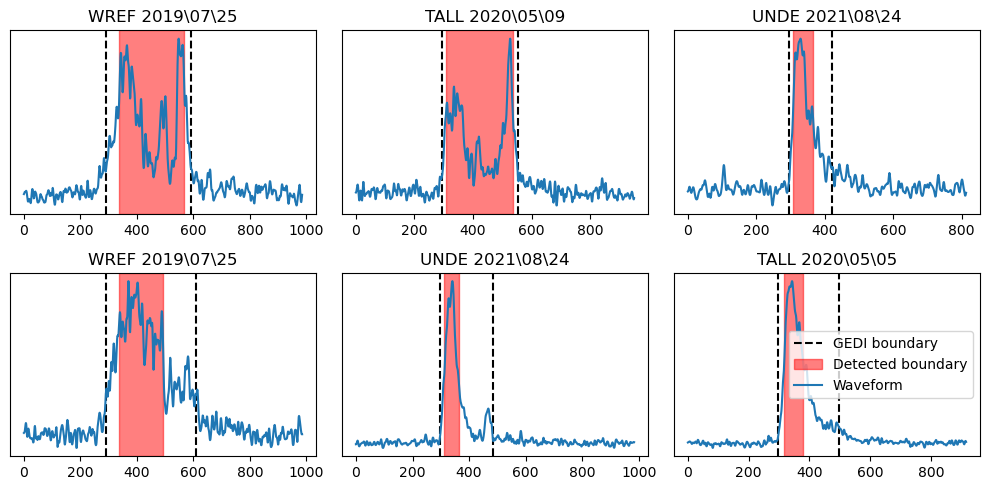

In [12]:
fig, axes = plt.subplots(2, 3, figsize=(10, 5))

waves_to_plot = np.random.randint(0, test_waveforms.shape[0], size=6)
for (wave, ax) in zip(waves_to_plot, axes.flatten()):
    plot_waveform_result(wave, ax=ax)

plt.tight_layout()
plt.legend()
plt.show()